In [1]:
import numpy as np
import sys
import time
import random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
from copy import deepcopy
import pickle 

sys.path.append('/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm')

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from word2vec_eltdm.word2vec_numpy import (
    Tokenizer, VocabCreator, DataLoader, TokenCleaner, Preprocessor,
    Subsampler, SimpleWord2Vec, Optimizer, CrossEntropy, NegWord2Vec,
    NegativeSamplingLoss, OptimizeNSL, evaluate, visualization_tsne, train_NSL,
    update_best_loss
)

## Get data and create vocab

In [3]:
datapath = "../data/text8.txt"

RATIO = 1
return_only_train = True
tokenizer = Tokenizer(datapath)
token_cleaner = TokenCleaner(freq_threshold=5)
vocab_creator = VocabCreator()
text8_dataset = Preprocessor(tokenizer, token_cleaner, vocab_creator, RATIO, return_only_train).preprocess()

In [4]:
print("Size of our vocabulary:", len(text8_dataset.tokens_to_id))

Size of our vocabulary: 63492


In [5]:
print("Number of tokens in our train dataset:", len(text8_dataset.train_tokens))

Number of tokens in our train dataset: 10566033


In [6]:
print("Number of tokens in our val dataset:", len(text8_dataset.val_tokens))

Number of tokens in our val dataset: 0


In [7]:
print("Number of tokens in our test dataset:", len(text8_dataset.test_tokens))

Number of tokens in our test dataset: 0


## Subsampling of frequent words, as in Mikolov 2013.

In [8]:
subsampler = Subsampler(text8_dataset.train_tokens)
text8_dataset.train_tokens, text8_dataset.frequencies = subsampler.subsample()

In [9]:
print("Size of our vocabulary after subsampling of frequent words, for train:", len(text8_dataset.tokens_to_id))

Size of our vocabulary after subsampling of frequent words, for train: 63492


In [10]:
print("Number of tokens in train dataset:", len(text8_dataset.train_tokens))

Number of tokens in train dataset: 3767955


## DataLoader

In [11]:
window = 5
batch_size = 512
train_dataloader = DataLoader(text8_dataset, text8_dataset.train_tokens, window, batch_size)

## Model

In [12]:
# defining the parameters
len_vocab = len(text8_dataset.tokens_to_id)
embedding_size = 300
learning_rate = 3e-2 # 5e-2
n_samples = 5
BEST_VAL_LOSS = 2.83
epochs = 20

# hyperparameters for optimizer
decay_rate = learning_rate / epochs
method = "time_based" # or "none", "exp_decay", "step_decay", "time_based"

# Get our noise distribution
word_freqs = np.array(sorted(text8_dataset.frequencies.values(), reverse=True))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75))

# instantiate the model
#model = NegWord2Vec(
#    len_vocab,
#    embedding_size,
#    noise_dist=noise_dist,
#    best_val_loss=BEST_VAL_LOSS
#)
#model.initialize_weights()

# Load previous model

with open("../word2vec_eltdm/models/NegWord2Vec_2.83.p", "rb") as file:
    model = pickle.load(file)
model = model["NegWord2Vec"]

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = OptimizeNSL(model,learning_rate, decay_rate, method)

## Training

In [13]:
# train for some number of epochs
train_loss_history = []
tbar = trange(epochs)

for epoch in tbar:
    print(f"###################### EPOCH {epoch} ###########################")
    
    train_loss = train_NSL(model, train_dataloader, criterion, optimizer, n_samples)
    print("Training loss:", train_loss)
    train_loss_history.append(train_loss)
    
    # Keep track of the best model
    update_best_loss(model, train_loss)
    
    # update learning rate 
    optimizer.update_lr(epoch)
    
    embeddings = model.W1
    evaluate(embeddings, text8_dataset.id_to_tokens, nb_words=20)

  0%|          | 0/20 [00:00<?, ?it/s]

###################### EPOCH 0 ###########################


  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.9088321407092863
year | gregorian, january, day, elected, calendar
x | frac, inverse, finite, vector, integers
external | links, www, http, website, online
century | texts, reformation, succession, churches, medieval
links | external, online, wiki, org, website
english | linguist, ois, writer, french, author
would | eventually, forced, could, merely, certain
states | united, constitution, agreements, governments, commonwealth
united | relations, union, independence, governments, signed
series | simpsons, movie, television, movies, girl
remaining | gregorian, leap, days, year, crushed
reached | yugoslav, regions, west, region, harsh
animal | acid, plant, cells, insects, genes
billion | imports, exports, unemployment, sector, commodities
signed | democratic, treaty, approved, constitution, governments
individuals | couples, individual, alone, relationships, social
hebrew | bible, biblical, scriptures, christian, testament
location | km, geography, elevation, kilometers, 

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7553882736521227
Now best model has 2.7553882736521227 loss
Saving model
century | reformation, texts, succession, churches, jewish
would | eventually, forced, could, however, effectively
example | definition, dimensional, definitions, object, theorem
english | linguist, french, ois, italian, writer
states | united, constitution, agreements, governments, commonwealth
known | divinity, ventral, disciples, canon, literal
like | happens, memory, described, infinite, interface
different | defined, word, refers, definition, cannot
much | easier, generally, free, many, tend
war | troops, battle, invasion, allied, forces
wars | ottoman, war, empire, troops, uprising
computers | applications, hardware, software, interface, data
medicine | physicist, cancer, baron, george, scientist
motion | atoms, frequency, molecules, detect, electrons
translation | translations, translated, testament, hebrew, dictionary
supported | reforms, committee, institution, constitution, decisions
mar

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.726565602540925
Now best model has 2.726565602540925 loss
Saving model
history | christian, roman, bc, jews, ancient
early | ages, divine, succession, gospel, luke
language | languages, spoken, word, linguistic, dialects
different | defined, word, refers, definition, cannot
also | well, somewhat, including, improving, several
name | trinity, greek, hebrew, derives, th
well | also, opposed, good, continue, periods
since | weak, regulations, consumers, limited, required
five | one, two, six, parma, nine
see | ancient, noun, languages, middle, tiberian
lack | labor, shortage, cannot, power, seem
billion | imports, exports, unemployment, sector, commodities
regarded | belief, scriptures, scholars, doctrines, judaism
table | linear, input, discrete, finite, multiple
internal | generate, allow, defined, dependent, product
response | decisions, standards, achieve, others, opposed
hebrew | bible, biblical, scriptures, christian, testament
composer | james, musician, laureate, 

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.725412985283744
Now best model has 2.725412985283744 loss
Saving model
time | announced, willing, would, soon, select
several | extensively, operate, course, caused, also
would | eventually, forced, could, however, effectively
see | ancient, noun, languages, middle, tiberian
based | platform, server, libraries, internet, applications
may | framework, whether, legislative, laws, required
country | africa, central, border, south, territorial
list | org, database, external, online, web
also | well, somewhat, including, improving, several
united | relations, union, ceded, states, independence
clear | idea, tend, neither, words, determine
round | normally, seldom, length, moving, dust
computers | applications, hardware, software, interface, data
province | southern, ottoman, eastern, republic, territory
ship | hazardous, ozone, terrain, northeast, coast
medicine | physicist, cancer, baron, george, scientist
daughter | father, footballer, composer, mistress, wife
speech | le

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7252877267563056
Now best model has 2.7252877267563056 loss
Saving model
states | united, constitution, agreements, governments, commonwealth
language | languages, spoken, word, linguistic, dialects
year | gregorian, january, day, elected, calendar
de | fran, statesman, emperor, french, duke
new | center, york, nine, came, presidency
system | systems, allows, proprietary, product, software
high | increases, grid, heating, approximately, considerably
number | parameters, numbers, method, functions, defined
state | constitution, elections, democracy, vote, ministers
years | mortality, male, expectancy, migration, age
appointed | elected, election, cabinet, unicameral, legislative
reading | bibliography, poetry, edition, translated, paperback
supported | reforms, committee, institution, constitution, decisions
consider | viewed, true, argument, definitions, expressed
conflict | opposition, constitution, reform, peaceful, political
martin | ois, artist, playwright, politic

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7253111729135955
common | language, appropriate, object, argument, definitions
c | detect, ion, equation, denoted, electron
american | cricketer, politician, actress, laureate, baseball
would | eventually, forced, could, however, effectively
state | constitution, elections, democracy, vote, ministers
f | int, denoted, frac, inverse, vector
de | fran, statesman, emperor, french, duke
eight | nine, four, one, ferdinand, french
english | linguist, french, ois, italian, writer
first | nine, upcoming, week, march, shortly
temperature | temperatures, heat, molecules, heating, flow
sold | selling, users, running, facilities, hardware
sexual | thoughts, individuals, oral, claiming, refute
committee | opposition, governments, democratic, senate, parliamentary
motion | atoms, frequency, molecules, detect, electrons
consider | viewed, true, argument, definitions, expressed
ed | press, richard, isbn, cambridge, pp
station | stations, satellite, ocean, cable, radio
martin | ois, ar

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.725338179820664
south | north, east, border, gulf, sea
game | featuring, games, super, team, players
zero | one, two, nine, three, five
although | however, choosing, put, contrast, declined
n | sum, frac, x, inverse, algebraic
modern | colloquial, humans, vowel, refer, suggest
new | center, york, nine, came, presidency
number | parameters, numbers, method, functions, defined
links | external, online, website, org, com
american | cricketer, politician, actress, laureate, baseball
calendar | gregorian, leap, holidays, day, observances
ed | press, richard, isbn, cambridge, pp
sold | selling, users, running, facilities, hardware
conflict | opposition, constitution, reform, peaceful, political
kind | context, equations, expressions, broader, phenomena
users | interface, software, applications, computers, server
purpose | cost, making, internal, requirement, generated
carbon | hydrogen, dioxide, thermal, chemical, gases
intended | application, flexibility, obtain, necessary,

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.725330716208341
second | incarnated, squads, illinois, close, longshanks
e | int, relation, sum, geometric, defined
form | depends, effects, techniques, accurately, arbitrary
history | christian, roman, bc, jews, ancient
many | even, often, rather, consequently, depends
state | constitution, elections, democracy, vote, ministers
five | one, two, six, parma, nine
different | defined, word, refers, definition, cannot
common | language, appropriate, object, argument, definitions
eight | nine, four, one, ferdinand, french
environment | biodiversity, wastes, pollution, hazardous, wetlands
noted | understand, beliefs, canonical, seems, documented
temperature | temperatures, heat, molecules, heating, flow
performed | dressed, girl, adolescence, songs, bob
values | mathematical, vector, equation, binary, equations
wars | ottoman, war, empire, troops, uprising
miles | km, elevations, coastal, temperate, southwest
approximately | km, temperatures, elevations, seasonal, density
p

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.725293247111067
government | coalition, governments, vote, party, constitution
th | roman, empire, became, conquered, anglo
several | extensively, operate, course, caused, also
city | county, north, located, towns, east
people | political, referendum, leaders, government, authority
life | mother, soul, writings, rumors, judgment
early | ages, divine, succession, gospel, luke
see | ancient, noun, languages, middle, tiberian
german | french, polish, duke, italian, charles
like | happens, memory, described, interface, infinite
noted | understand, beliefs, canonical, seems, documented
sold | selling, users, running, facilities, hardware
performed | dressed, girl, adolescence, songs, bob
electric | electrons, electrical, signal, magnetic, input
chicago | baseball, appearances, university, angeles, bob
motion | atoms, frequency, molecules, detect, electrons
bridge | road, bed, atlanta, volcanism, exhibition
multiple | hardware, computers, embedded, input, software
translatio

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7252816002599696
Now best model has 2.7252816002599696 loss
Saving model
year | gregorian, january, day, elected, calendar
zero | one, two, nine, three, five
system | systems, allows, proprietary, product, software
n | sum, frac, x, inverse, algebraic
work | human, published, collection, programs, label
use | input, allows, applications, systems, cannot
state | constitution, elections, democracy, vote, ministers
seven | nine, peruvian, six, three, one
second | incarnated, squads, illinois, close, longshanks
name | trinity, greek, hebrew, derives, th
speaking | secular, catholic, christianity, christian, religion
miles | km, elevations, coastal, temperate, southwest
animal | acid, plant, cells, insects, genes
comes | phonetic, similarly, shape, adjectives, ancestor
hebrew | bible, biblical, scriptures, christian, testament
acts | political, rights, doctrine, responsibility, resignation
signed | democratic, treaty, constitution, approved, constitutional
billion | imports

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7252763863526046
Now best model has 2.7252763863526046 loss
Saving model
x | frac, inverse, finite, integers, vector
language | languages, spoken, word, linguistic, dialects
city | county, north, located, towns, east
became | leadership, victory, habsburg, monarchy, opposition
german | french, polish, duke, italian, charles
external | links, www, http, website, online
long | spot, protect, back, pattern, placed
people | political, referendum, leaders, government, authority
zero | one, two, nine, three, five
c | detect, ion, equation, denoted, electron
ad | christianity, jewish, christians, roman, medieval
worked | cruelty, poet, allen, got, bruce
station | stations, satellite, ocean, cable, radio
remaining | gregorian, leap, year, days, tribes
medicine | physicist, cancer, baron, george, scientist
composer | james, musician, laureate, actor, footballer
individuals | couples, individual, alone, relationships, social
labour | labor, economic, socialist, policy, governmen

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7252233850736785
Now best model has 2.7252233850736785 loss
Saving model
music | album, songs, lyrics, jazz, concert
number | parameters, numbers, method, functions, defined
early | ages, divine, succession, gospel, luke
life | mother, soul, writings, rumors, judgment
another | reason, something, know, interpretations, find
part | western, fled, region, east, west
although | however, choosing, put, contrast, declined
much | easier, generally, free, many, tend
external | links, www, http, website, online
also | well, somewhat, including, improving, several
round | normally, seldom, length, moving, dust
province | southern, ottoman, eastern, republic, territory
response | decisions, standards, achieve, others, opposed
billion | imports, exports, unemployment, sector, commodities
centuries | empire, middle, eastern, ottoman, arab
electric | electrons, electrical, signal, magnetic, input
ad | christianity, jewish, christians, roman, medieval
hebrew | bible, biblical, scrip

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.725365319453926
used | data, applications, variable, correct, system
years | mortality, male, expectancy, migration, age
e | int, relation, sum, geometric, defined
language | languages, spoken, word, linguistic, dialects
x | frac, inverse, finite, integers, vector
th | roman, empire, became, conquered, anglo
new | center, york, nine, came, presidency
world | war, remained, nations, western, germany
see | ancient, noun, languages, middle, tiberian
king | duke, emperor, pope, maximilian, habsburg
electric | electrons, electrical, signal, magnetic, input
remain | legal, wealth, enforce, factories, grants
christianity | christian, orthodox, roman, christians, catholic
evolution | hypothesis, studies, explain, theory, study
ad | christianity, jewish, christians, roman, medieval
sets | subsets, finite, int, subset, dimensional
purpose | cost, making, internal, requirement, generated
polish | german, henri, marshal, politician, austrian
ethnic | nationality, adjective, muslim

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7253566679497574
state | constitution, elections, democracy, vote, ministers
people | political, referendum, leaders, government, authority
u | government, presidential, states, missiles, commonwealth
one | nine, zero, five, six, four
first | nine, upcoming, week, march, shortly
university | ed, universities, york, college, colleges
king | duke, emperor, pope, maximilian, habsburg
new | center, york, nine, came, presidency
united | relations, union, ceded, states, independence
life | mother, soul, writings, rumors, judgment
sets | subsets, finite, int, subset, dimensional
purpose | cost, making, internal, requirement, generated
beyond | formulation, hypotheses, circumstances, proponents, prone
flight | air, motor, helicopter, speed, boeing
sexual | thoughts, individuals, oral, claiming, refute
ed | press, richard, isbn, cambridge, pp
microsoft | software, os, interface, unix, windows
agreement | governments, ratification, legislation, referendum, economic
necessary | c

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.725314992812837
french | german, italian, statesman, jean, johann
known | divinity, ventral, disciples, canon, literal
set | product, finite, vector, continuous, hardware
often | enables, makes, precise, manner, happens
time | announced, willing, would, soon, select
later | became, innocent, father, wife, son
example | definition, dimensional, definitions, object, theorem
nine | two, eight, one, seven, zero
city | county, north, located, towns, east
american | cricketer, politician, actress, laureate, baseball
wars | ottoman, war, empire, troops, uprising
sets | subsets, finite, int, subset, dimensional
remain | legal, wealth, enforce, factories, grants
physics | mechanics, equation, mathematical, equations, electromagnetic
labour | labor, economic, socialist, policy, governments
hebrew | bible, biblical, scriptures, christian, testament
ad | christianity, jewish, christians, roman, medieval
consider | viewed, true, argument, definitions, expressed
lack | labor, shorta

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.72529970518084
state | constitution, elections, democracy, vote, ministers
th | roman, empire, became, conquered, anglo
name | trinity, greek, hebrew, derives, th
modern | colloquial, humans, vowel, refer, suggest
number | parameters, numbers, method, functions, defined
see | ancient, noun, languages, middle, tiberian
well | also, opposed, good, continue, periods
many | even, often, rather, consequently, depends
six | seven, one, five, two, three
three | four, one, zero, seven, six
ethnic | nationality, adjective, muslims, indigenous, arab
kind | context, equations, expressions, broader, phenomena
brown | blonde, songwriter, chris, ernie, nick
convention | committee, legal, parliament, treaties, party
environment | biodiversity, wastes, pollution, hazardous, wetlands
location | km, elevation, geography, kilometers, lakes
ad | christianity, jewish, christians, roman, medieval
management | applications, interfaces, software, servers, computers
electric | electrons, elect

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7254539393561337
de | fran, statesman, emperor, french, duke
eight | nine, four, one, ferdinand, french
six | seven, one, five, two, three
b | composer, chemist, theologian, p, physicist
form | depends, effects, techniques, accurately, arbitrary
made | quickly, move, would, almost, patch
example | definition, dimensional, definitions, object, theorem
g | equation, h, integers, mathbf, algebraic
could | ways, money, remove, determine, must
years | mortality, male, expectancy, migration, age
station | stations, satellite, ocean, cable, radio
ad | christianity, jewish, christians, roman, medieval
ethnic | nationality, adjective, muslims, indigenous, arab
convention | committee, legal, parliament, treaties, party
sir | composer, politician, writer, laureate, physicist
kind | context, equations, expressions, broader, phenomena
consider | viewed, true, argument, definitions, expressed
animal | acid, plant, cells, insects, genes
chicago | baseball, appearances, university, an

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.7252553121392316
system | systems, allows, proprietary, product, software
years | mortality, male, expectancy, migration, age
although | however, choosing, put, contrast, declined
long | spot, protect, back, pattern, placed
called | diagram, suppose, repetition, objects, depending
king | duke, emperor, pope, maximilian, habsburg
war | troops, battle, invasion, allied, forces
based | platform, server, libraries, internet, applications
work | human, published, collection, programs, label
zero | one, two, nine, three, five
write | compatible, abstraction, variables, interpreter, software
sex | infant, female, migrant, mortality, birth
consider | viewed, true, argument, definitions, expressed
table | linear, input, discrete, finite, multiple
summer | temperate, summers, warm, winters, beaches
places | around, spoken, eastern, reaches, trough
clear | idea, tend, neither, words, determine
beyond | formulation, hypotheses, circumstances, proponents, prone
remain | legal, weal

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.725314046260483
g | equation, h, integers, mathbf, algebraic
early | ages, divine, succession, gospel, luke
although | however, choosing, put, contrast, declined
nine | two, eight, one, seven, zero
may | framework, whether, legislative, laws, required
seven | nine, peruvian, six, three, one
later | became, innocent, father, wife, son
also | well, somewhat, including, improving, several
often | enables, makes, precise, manner, happens
work | human, published, collection, programs, label
brown | blonde, songwriter, chris, ernie, nick
border | coastal, northeast, bordered, mountains, southeast
consider | viewed, true, argument, definitions, expressed
agreement | governments, ratification, legislation, referendum, economic
ed | press, richard, isbn, cambridge, pp
paper | oriented, device, limit, cheaper, application
multiple | hardware, computers, embedded, input, software
places | around, spoken, eastern, reaches, trough
evolution | hypothesis, studies, explain, theory, s

  0%|          | 0/7360 [00:00<?, ?it/s]

Training loss: 2.725249842834443
world | war, remained, nations, western, germany
history | christian, roman, bc, jews, ancient
could | ways, money, remove, determine, must
u | government, presidential, states, missiles, commonwealth
however | increasingly, practice, although, cannot, opposed
early | ages, divine, succession, gospel, luke
modern | colloquial, humans, vowel, refer, suggest
government | coalition, governments, vote, party, constitution
known | divinity, ventral, disciples, canon, literal
major | states, largely, mid, financial, security
ad | christianity, jewish, christians, roman, medieval
flight | air, motor, helicopter, speed, boeing
hebrew | bible, biblical, scriptures, christian, testament
brown | blonde, songwriter, chris, ernie, nick
table | linear, input, discrete, finite, multiple
lack | labor, shortage, cannot, power, seem
medicine | physicist, cancer, baron, george, scientist
refers | definition, word, interpretation, explicitly, different
miles | km, elevatio

## Evaluation on the task of word similarities

In [15]:
filepath = "../word2vec_eltdm/models/NegWord2Vec_2.7252233850736785.p"
with open(filepath, "rb") as file:
    model = pickle.load(file)

In [16]:
model = model["NegWord2Vec"]
embeddings = model.best_W1

### Evaluate using cosine similarity

In [17]:
evaluate(embeddings, text8_dataset.id_to_tokens, nb_words=20)

power | sector, decisions, government, purchasing, income
time | announced, willing, would, soon, select
became | leadership, victory, habsburg, monarchy, opposition
university | ed, universities, york, college, colleges
british | american, scottish, born, businessman, former
n | sum, frac, x, inverse, algebraic
state | constitution, elections, democracy, vote, ministers
could | ways, money, remove, determine, must
south | north, east, border, gulf, sea
th | roman, empire, became, conquered, anglo
environment | biodiversity, wastes, pollution, hazardous, wetlands
round | normally, seldom, length, moving, dust
billion | imports, exports, unemployment, sector, commodities
www | http, org, com, edu, external
faith | christianity, church, christians, orthodox, protestant
martin | ois, artist, playwright, politician, laureate
kind | context, equations, expressions, broader, phenomena
flight | air, motor, helicopter, speed, boeing
climate | humid, tropical, temperate, winters, summers
approx

### t-SNE embedding visualisation

/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


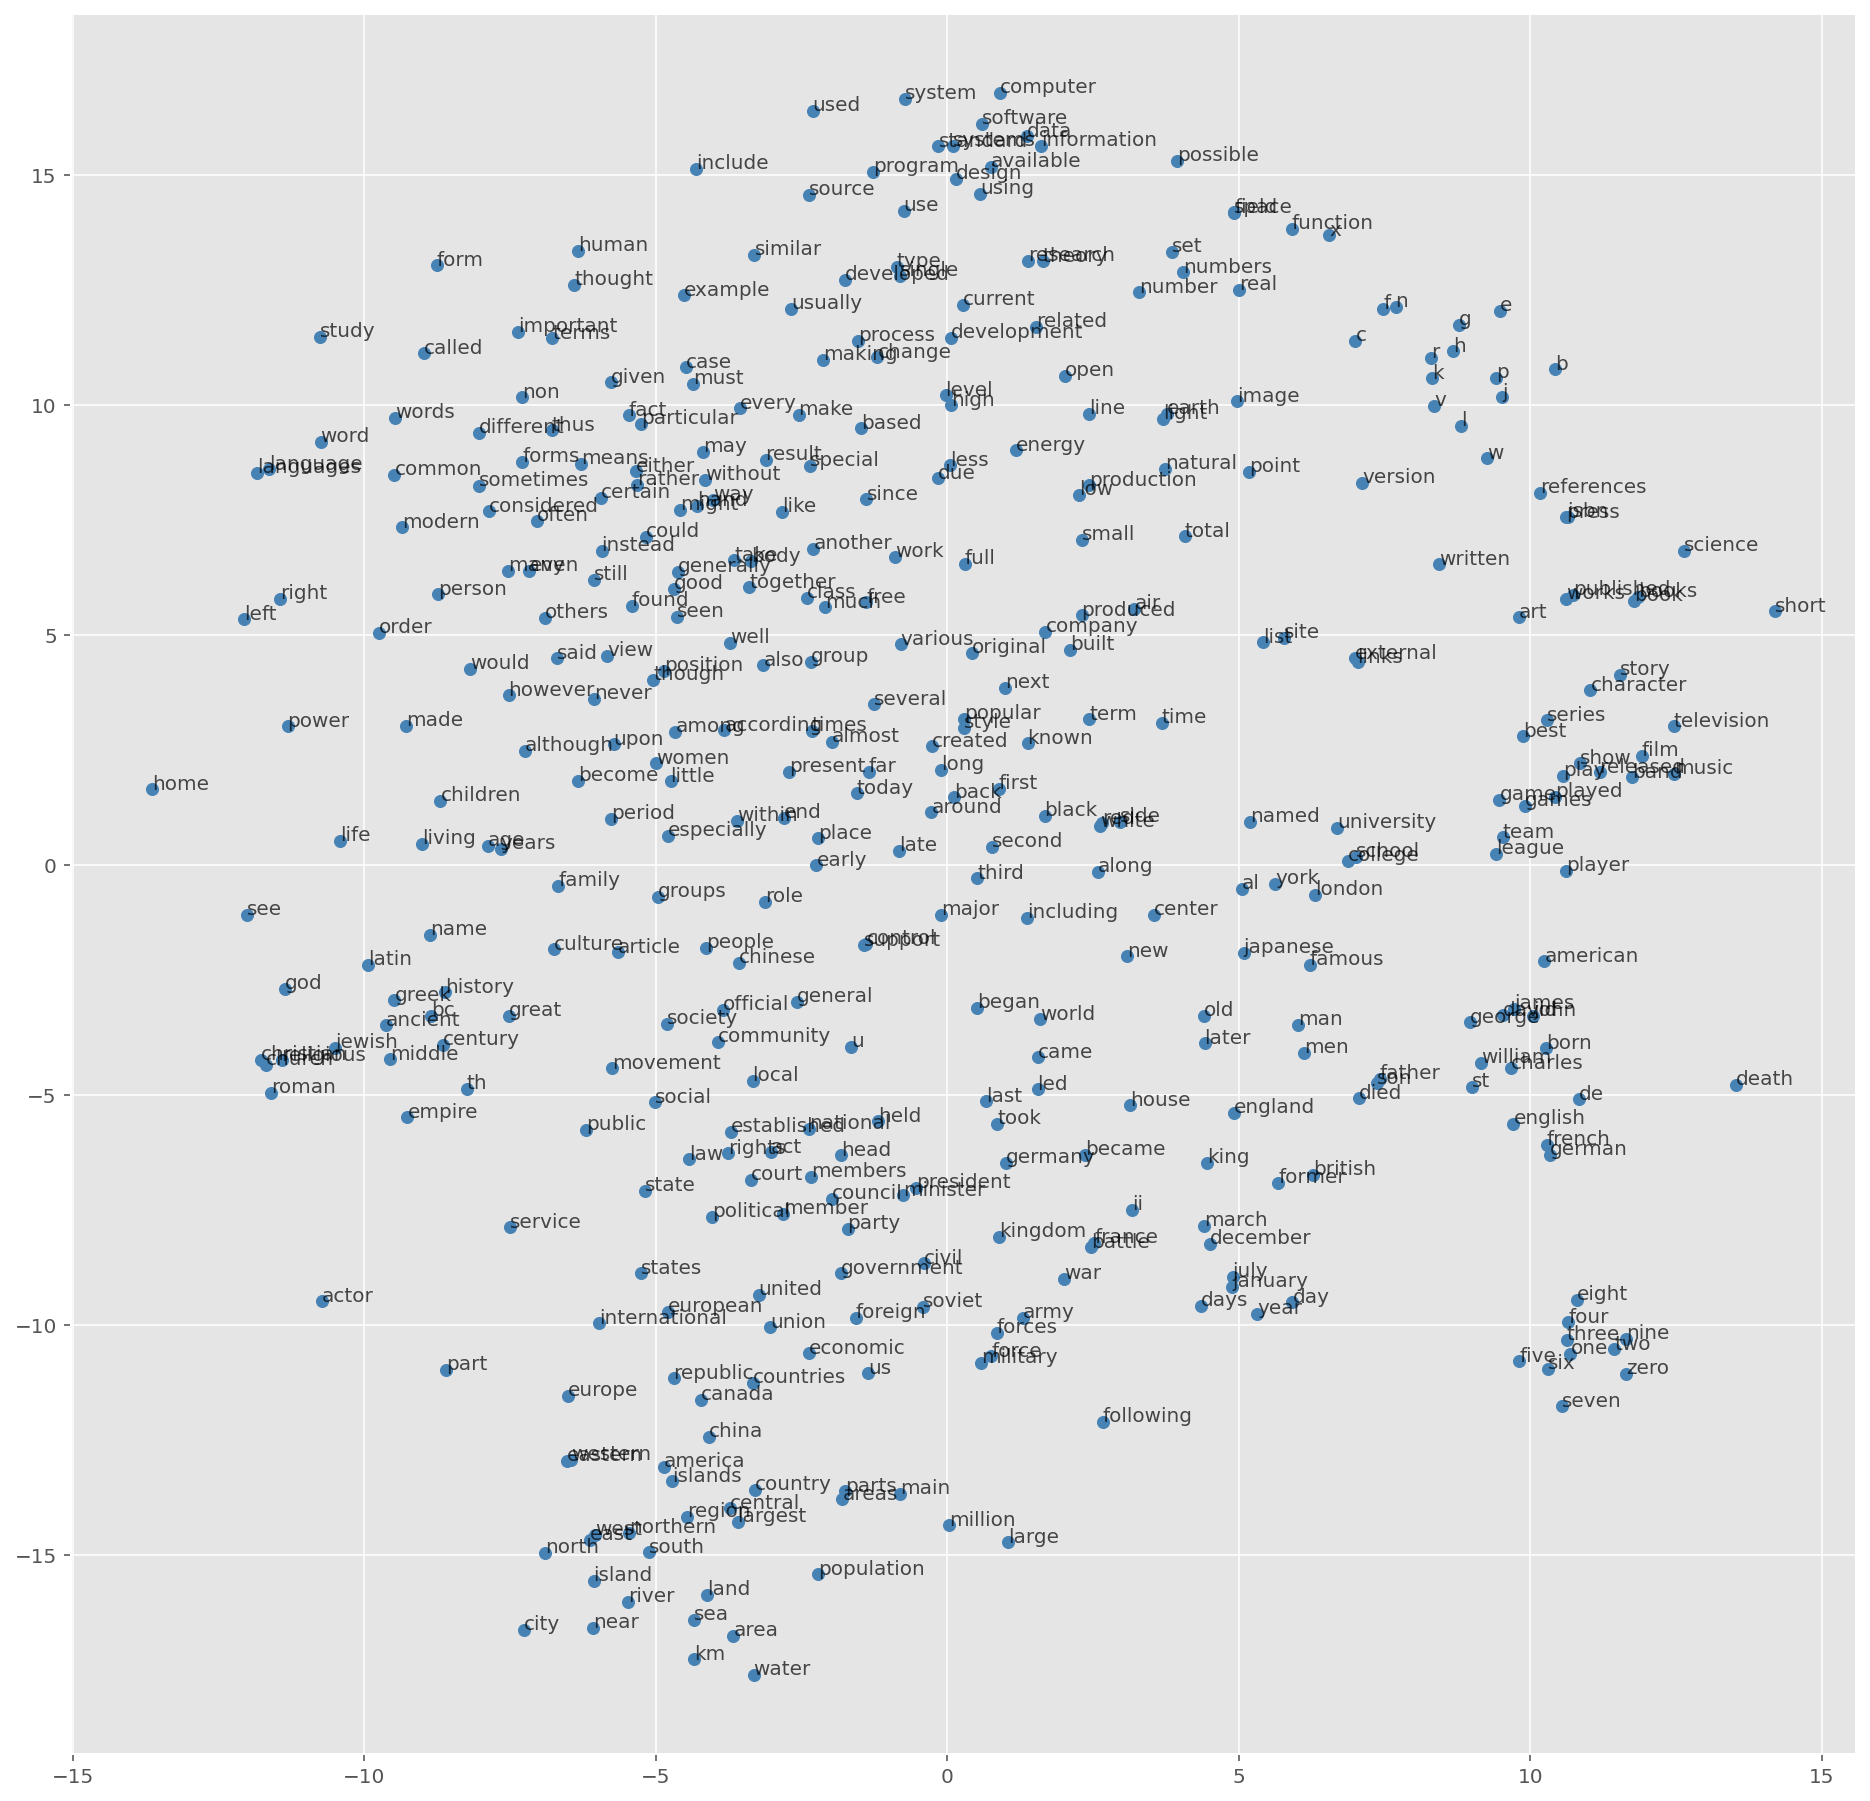

In [18]:
visualization_tsne(embeddings, text8_dataset.id_to_tokens, nb_words = 400)